In [1]:
# MLP

In [2]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# DSP data
fpath = "../../data/DNN_data/"

sig = np.load(fpath + "data_signal" + ".npy")
artifact = np.load(fpath + "data_sine_wave" + ".npy")
sig_with_artifact = np.load(fpath + "data_signal_with_sine" + ".npy")

sig_with_artifact.shape

(1000, 4000)

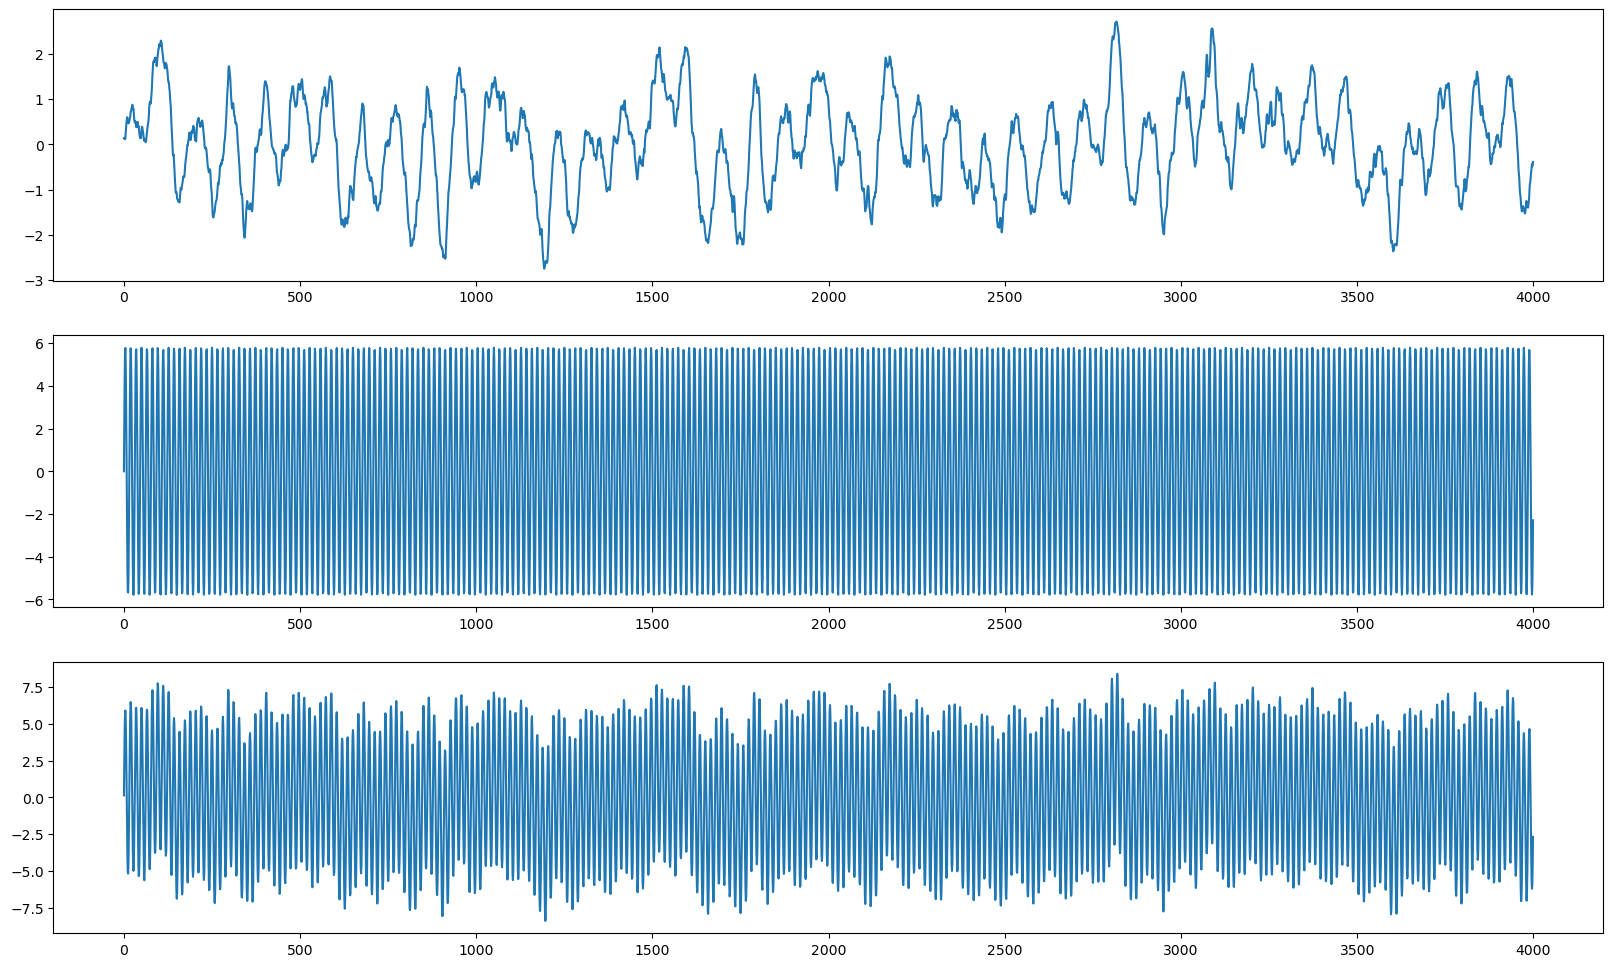

In [4]:
# example for loading data
plt.figure(figsize=(20,12))
plt.subplot(3, 1, 1)
plt.plot(sig[0, :])
plt.subplot(3, 1, 2)
plt.plot(artifact[0, :])
plt.subplot(3, 1, 3)
plt.plot(sig_with_artifact[0, :])
plt.show()

In [5]:
X = sig_with_artifact
y = sig

# train/test 데이터셋 분리 (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_test1 = y_test

# numpy array를 tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# StandardScaler를 사용하여 데이터 스케일링
scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_train_scaled = scaler_x.fit_transform(X_train)
x_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# 차원 추가
x_train_scaled = x_train_scaled.reshape((700, 4000, 1))

# 데이터셋 크기 확인
print(f"x_train_scaled shape: {x_train_scaled.shape}")
print(f"y_train_scaled shape: {y_train_scaled.shape}")

# TensorDataset을 사용하여 데이터셋 생성
train_dataset = TensorDataset(torch.tensor(x_train_scaled, dtype=torch.float32), torch.tensor(y_train_scaled, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(x_test_scaled, dtype=torch.float32), torch.tensor(y_test_scaled, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)



x_train_scaled shape: (700, 4000, 1)
y_train_scaled shape: (700, 4000)


In [6]:
# DNN 모델 정의
class BrainSignalDNN(nn.Module):
    def __init__(self):
        super(BrainSignalDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=x_train_scaled.shape[2], out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=1)

    def forward(self, input_data):
        #print("input shape: ", input_data.shape)
        x = F.relu(self.fc1(input_data))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = F.relu(self.fc3(x))
        x = self.drop(x)
        x = self.fc4(x).squeeze(-1)
        return x

# 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001
model = BrainSignalDNN().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)


BrainSignalDNN(
  (fc1): Linear(in_features=1, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)


In [7]:
# 모델 학습
num_epochs = 200
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device), labels.to(device)

        train = features.view(features.shape[0], 4000, 1)

        # Forward pass
        outputs = model(train)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    loss_list.append(loss.item())
    iteration_list.append(epoch+1)


Epoch [1/200], Step [22/22], Loss: 0.1278
Epoch [51/200], Step [22/22], Loss: 0.0942
Epoch [101/200], Step [22/22], Loss: 0.0731
Epoch [151/200], Step [22/22], Loss: 0.0950


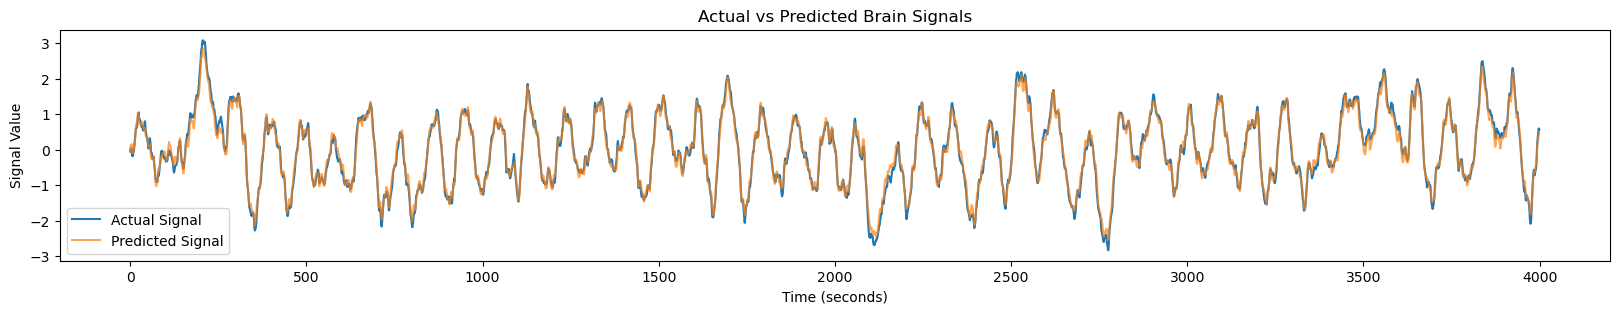

Mean Absolute Error: 0.10092356048170036
Mean Squared Error: 0.015822503374387595


In [8]:
# 모델 평가
model.eval()
with torch.no_grad():
    y_pred_list = []
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        features = features.view(features.shape[0], 4000, 1)
        outputs = model(features)
        y_pred_list.append(outputs.cpu().numpy())

y_pred = np.concatenate(y_pred_list, axis=0)
y_pred = scaler_y.inverse_transform(y_pred)

y_test = y_test1

# mse_loss = mean_absolute_error(y_test, y_pred)
# print(f"Mean Squared Error: {mse_loss}")

# criterion = nn.MSELoss()
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
# y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
# mse_loss = criterion(y_test_tensor, y_pred_tensor)
# print(f"Mean Squared Error: {mse_loss.item()}")

predicted_signal = y_pred[0]
actual_signal = y_test[0]

# 결과 시각화
plt.figure(figsize=(20,3))
slice_size = 5
plt.plot(actual_signal, label='Actual Signal')
plt.plot(predicted_signal, label='Predicted Signal', alpha=0.7)
plt.xlabel("Time (seconds)")
plt.ylabel("Signal Value")
plt.legend()
plt.title('Actual vs Predicted Brain Signals')
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(actual_signal, predicted_signal)}")
print(f"Mean Squared Error: {mean_squared_error(actual_signal, predicted_signal)}")

In [2]:
n = len(predicted_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(predicted_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power1 = fft_predicted**2

fft_actual = np.fft.fft(actual_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power2 = fft_actual**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.log10(power2), label='Actual Signal', color='blue')
plt.plot(freqs, np.log10(power1), label='Predicted Signal', color='red')
plt.title('Power Spectrum of Actual vs Predicted Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power1), np.log10(power2))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power1), np.log10(power2))}")

NameError: name 'predicted_signal' is not defined